# Basic Concepts and Prototyping

## Example Model and toy data

model PEAK3

J0: B -> A; J0_Vmax*B/(J0_Km + B)
J1: A -> B; J1_Vmax*A/(J1_Km + A)

# State variables in the system
B=0
A=100

# Parameters in the system
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10

end


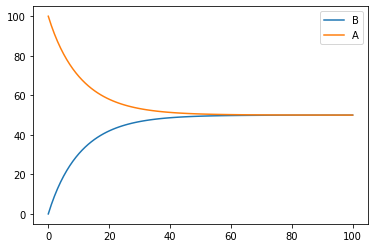

[  0.           1.01010101   2.02020202   3.03030303   4.04040404
   5.05050505   6.06060606   7.07070707   8.08080808   9.09090909
  10.1010101   11.11111111  12.12121212  13.13131313  14.14141414
  15.15151515  16.16161616  17.17171717  18.18181818  19.19191919
  20.2020202   21.21212121  22.22222222  23.23232323  24.24242424
  25.25252525  26.26262626  27.27272727  28.28282828  29.29292929
  30.3030303   31.31313131  32.32323232  33.33333333  34.34343434
  35.35353535  36.36363636  37.37373737  38.38383838  39.39393939
  40.4040404   41.41414141  42.42424242  43.43434343  44.44444444
  45.45454545  46.46464646  47.47474747  48.48484848  49.49494949
  50.50505051  51.51515152  52.52525253  53.53535354  54.54545455
  55.55555556  56.56565657  57.57575758  58.58585859  59.5959596
  60.60606061  61.61616162  62.62626263  63.63636364  64.64646465
  65.65656566  66.66666667  67.67676768  68.68686869  69.6969697
  70.70707071  71.71717172  72.72727273  73.73737374  74.74747475
  75.7575757

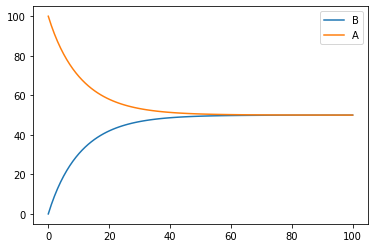

In [1]:
from cProfile import label
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

import matplotlib.pyplot as plt
import roadrunner


model = ModelBuilder('PEAK3')
model.add_reaction(Reaction(michaelis_menten, ('B',), ('A',)))
model.add_reaction(Reaction(michaelis_menten, ('A',), ('B',)))

print(model.get_antimony_model())

runner = roadrunner.RoadRunner(model.get_sbml_model())
res = runner.simulate(0, 100, 100)


states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.legend()
plt.show()
# runner.plot()

import numpy as np

print(res['time'])

def find_closest_idx(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx

print(find_closest_idx(res['time'], 50))

init_states = model.get_state_variables()
for k, v in init_states.items():
    runner[f'[{k}]'] = v

res = runner.simulate(0, 100, 100)
states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)


plt.legend()
plt.show()

[[90 30 20  5]
 [92 31 21  4]
 [93 29 26  6]]
[91.66666667 30.         22.33333333  5.        ]
[0.7200823  0.47140452 1.51535352 0.47140452]


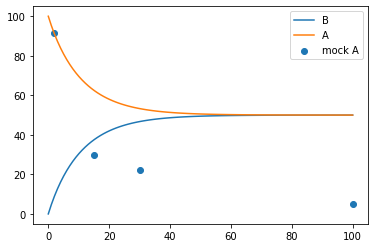

In [2]:
# toy data

import numpy as np

mock_A = [90, 30, 20, 5, 92, 31, 21, 4, 93, 29, 26, 6]
mock_A = np.array(mock_A).reshape(3,4)
mock_A_ave= np.average(mock_A, axis=0)
mock_A_std = np.std(mock_A, axis=0) / np.sqrt(mock_A.shape[0])


print(mock_A)
print(mock_A_ave)
print(mock_A_std)
mock_time = [2, 15, 30, 100]

states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

plt.scatter(mock_time, mock_A_ave, label='mock A')
plt.legend()
plt.show()


## Defining The Objective Function

In [3]:
import roadrunner
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Iterable, Tuple, List

class ExperimentalData:

    '''
    A wrapper for a dict that stores experimental data.
    '''

    def __init__(self):

        self.data = {}

    def add_data(self, time: Iterable, value: Iterable, std_error: Iterable, name: str):

        '''
        Add experimental data to the dict.
        '''

        assert len(time) == len(value) == len(std_error), 'time, value, and std_error must have the same length'

        if name in self.data:
            raise ValueError(f'Experimental data with name {name} already exists')

        self.data[name] = {'time': time, 'value': value, 'std_error': std_error}

    def get_names(self) -> List[str]:

        '''
        Get the names of the experimental data.
        '''

        return list(self.data.keys())

    def get_data(self, name: str) -> Dict:

        '''
        Get experimental data from the dict.
        '''

        if name not in self.data:
            raise ValueError(f'Experimental data with name {name} does not exist')

        return self.data[name]

    def get_data_tuple(self, name: str) -> Tuple[Iterable, Iterable, Iterable]:

        '''
        Get experimental data from the dict as a tuple.
        '''

        if name not in self.data:
            raise ValueError(f'Experimental data with name {name} does not exist')

        return self.data[name]['time'], self.data[name]['value'], self.data[name]['std_error']


def find_closest_idx(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx


def objective(p, model: roadrunner.RoadRunner, params: list, init_state_vars: dict, experimental_data: ExperimentalData, sim_time=100) -> np.array:
    
    # update parameters
    i = 0 
    while i < len(params):
        parameter, value = params[i], p[i]
        model.model[f'{parameter}'] = value
        i += 1

    # update initial state variables
    for k, value in init_state_vars.items():
        model.model[f'[{k}]'] = value
    
    model.integrator.relative_tolerance = 1e-8
    model.integrator.absolute_tolerance = 1e-8
    # simulate model
    try: 
        res = model.simulate(0, sim_time, sim_time)

    except Exception as e:
        # penalize gravely if simulation fails
        return 1e10

    # calculate objective
    j = 0
    for experimental_state in experimental_data.get_names():
        time, value, std_error = experimental_data.get_data_tuple(experimental_state)
        i = 0 
        while i < len(time):
            t, v, s = time[i], value[i], std_error[i]
            idx = np.argmin(np.abs(res['time'] - t)) # find closest index in sim time array compared to experimental time 
            model_value = res[f'[{experimental_state}]'][idx]
            objective_value = (model_value - v) / s
            j += objective_value ** 2
            i += 1 


    return j


In [4]:
# test objective function

from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

import matplotlib.pyplot as plt
import roadrunner
import numpy as np


model = ModelBuilder('PEAK3')
model.add_reaction(Reaction(michaelis_menten, ('B',), ('A',)))
model.add_reaction(Reaction(michaelis_menten, ('A',), ('B',)))

print(model.get_antimony_model())

runner = roadrunner.RoadRunner(model.get_sbml_model())

mock_A = [90, 30, 20, 5, 92, 31, 21, 4, 93, 29, 26, 6]
mock_A = np.array(mock_A).reshape(3,4)
mock_A_ave= np.average(mock_A, axis=0)
mock_A_std = np.std(mock_A, axis=0) / np.sqrt(mock_A.shape[0])
mock_time = [2, 15, 30, 100]

exp_data = ExperimentalData()
exp_data.add_data(mock_time, mock_A_ave, mock_A_std, 'A')

init_paramset = tuple(model.get_parameters().values())
init_states = model.get_state_variables()
params_name = list(model.get_parameters().keys())

print(params_name)
print(init_paramset)

known_err_array = [0,0,0,0]

print(objective(init_paramset, runner, params_name, init_states, exp_data, sim_time=100))

for i in range(1000):
    objective(init_paramset, runner, params_name, init_states, exp_data, sim_time=100)


model PEAK3

J0: B -> A; J0_Vmax*B/(J0_Km + B)
J1: A -> B; J1_Vmax*A/(J1_Km + A)

# State variables in the system
B=0
A=100

# Parameters in the system
J0_Km=100
J0_Vmax=10
J1_Km=100
J1_Vmax=10

end
['J0_Km', 'J0_Vmax', 'J1_Km', 'J1_Vmax']
(100, 10, 100, 10)
14238.004942693451


## Global Optimization using Scipy.differential_evolution

In [5]:
from scipy.optimize import rosen, differential_evolution
bounds = [(0, 2), (0, 2), (0, 2), (0, 2), (0, 2)]
result = differential_evolution(rosen, bounds, updating='deferred', workers=1)
print(result.x, result.fun)


[1. 1. 1. 1. 1.] 0.0


In [18]:
from scipy.optimize import rosen, differential_evolution
from joblib import Parallel, delayed, cpu_count

def create_bounds(params: list):
    bounds = []
    for param in params:
        bounds.append((param/10, param*10))
    return bounds

bounds = create_bounds(init_paramset)


n = 50
def parallel_loop(i):
    result = differential_evolution(objective, bounds, popsize=500, tol=0.001, maxiter=50, args=(runner, params_name, init_states, exp_data, 100))
    return (result.x, result.fun)
all_paramset = Parallel(n_jobs=cpu_count())(delayed(parallel_loop)(i) for i in range(n))


## Visualising uniqueness of parameter sets using parallel coordinates

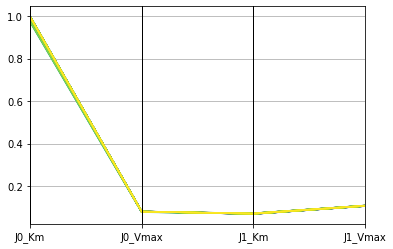

In [19]:
import pandas as pd
paramset_dict = {}
obj_list = []
paramset_list = []
for i in range(len(all_paramset)):
    paramset, obj = all_paramset[i]
    paramset_list.append(paramset)
    obj_list.append(obj)

paramset_list = np.array(paramset_list)

paramset_dict['error'] = obj_list
for i in range(len(params_name)):
    paramset_dict[params_name[i]] = paramset_list[:,i]

df = pd.DataFrame(paramset_dict)

def generate_min_and_max_bound(bounds, params_name):
    min_bound = {}
    max_bound = {}
    for i, p in enumerate(params_name):
        min_bound[p] = bounds[i][0]
        max_bound[p] = bounds[i][1]
    
    return min_bound, max_bound

pdf_min, pdf_max = generate_min_and_max_bound(bounds, params_name)


def normalize(df: pd.DataFrame, pdf_min, pdf_max):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != 'error':
            max_value = pdf_max[feature_name]
            min_value = pdf_min[feature_name]
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

normalized_df = normalize(df, pdf_min, pdf_max)

pd.plotting.parallel_coordinates(normalized_df, 'error', colormap='viridis')

plt.gca().legend_.remove()


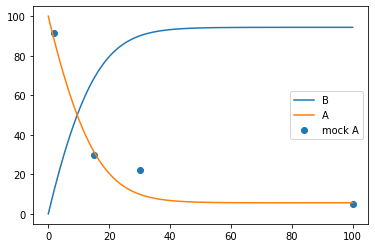

In [20]:
params_name = list(model.get_parameters().keys())

best_fit_df = df[df['error'] == df['error'].min()]
best_fit = best_fit_df.iloc[0].to_numpy()[1:]

for i in range(len(params_name)):
    runner.model[f'{params_name[i]}'] = best_fit[i]
    # print(runner.model[f'{params_name[i]}'])
    
init_states = model.get_state_variables()
for k, v in init_states.items():
    runner[f'[{k}]'] = v

res = runner.simulate(0, 100, 100)
states = model.get_state_variables().keys()
for s in states:
    # print(s)
    plt.plot(res['time'], res[f'[{s}]'], label=s)

# print(res)
plt.scatter(mock_time, mock_A_ave, label='mock A')

# plt.scatter(mock_time, mock_A[0,:], label='mock A')
# plt.scatter(mock_time, mock_A[1,:], label='mock A')
# plt.scatter(mock_time, mock_A[2,:], label='mock A')
plt.legend()
plt.show()


In [21]:
import plotly.express as px
import plotly.graph_objects as go


def construct_dimensions(df):
    dimensions = []
    for feature_name in df.columns:
        if feature_name != 'error':
            dimensions.append(
                dict(range=[0, 1], label=feature_name, values=df[feature_name]))
    return dimensions

# normalized_df = px.data.tips()
# dimen = construct_dimensions(normalized_df)
# fig = go.Figure(data=go.Parcoords(dimensions=dimen))


fig = go.Figure(data=go.Parcoords(line=dict(
    color=normalized_df['error'], colorscale=px.colors.sequential.Viridis), 
    dimensions=construct_dimensions(normalized_df)))

# fig = px.parallel_coordinates(
#     normalized_df, dimensions=params_name, color='error', color_continuous_scale='Viridis')
fig.show()
